In [109]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import plt_utils

hyperparameters = {
    "retriever.n_docs": 2,  # for each side
    "evaluator.n_prompts": 5,
    "evaluator.max_new_tokens": 20,
}

with open("result_paths_latency_opt.json", 'r') as f:
    latency_opt = {int(k): v for k, v in json.load(f).items()}

with open("result_paths_latency_qwen.json", 'r') as f:
    latency_qwen = {int(k): v for k, v in json.load(f).items()}

stderrs_opt = {}
for group in latency_opt:
    stderrs_opt[group] = {}
    latency_opt[group]["CRCG/Device"] = latency_opt[0]["CRCG/Device"]
    latency_opt[group]["CRCG/Cloud"] = latency_opt[0]["CRCG/Cloud"]

for group in latency_opt:
    for method in latency_opt[group]:
        with open(Path("..") / latency_opt[group][method]) as f:
            stats = json.load(f)
        data = [stat['LatencyPerToken'] for stat in stats]
        latency_per_token = 1000 * np.mean(data)
        latency_opt[group][method] = latency_per_token
        stderrs_opt[group][method] = np.std(data) / np.sqrt(len(data)) * 1e3

stderrs_qwen = {}
for group in latency_qwen:
    latency_qwen[group]["CRCG/Device"] = latency_qwen[0]["CRCG/Device"]
    latency_qwen[group]["CRCG/Cloud"] = latency_qwen[0]["CRCG/Cloud"]
    stderrs_qwen[group] = {}

for group in latency_qwen:
    for method in latency_qwen[group]:
        if latency_qwen[group][method] == "":
            latency_qwen[group][method] = 0
            continue
        with open(Path("..") / latency_qwen[group][method]) as f:
            stats = json.load(f)
        data = [stat['LatencyPerToken'] for stat in stats]
        latency_per_token = 1000 * np.mean(data)
        stderrs_qwen[group][method] = np.std(data) / np.sqrt(len(data)) * 1e3
        latency_qwen[group][method] = latency_per_token

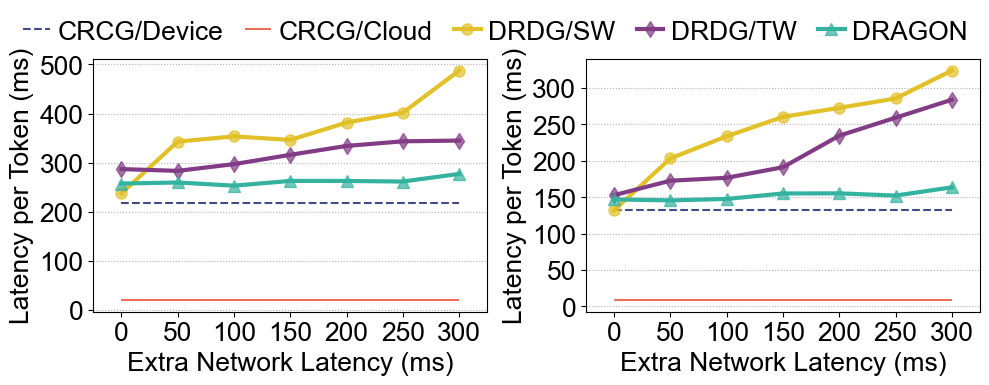

In [110]:
def hex2rgb(hex_color: str):
    hex_color = hex_color.lstrip('#')
    rgb_color = list(int(hex_color[i:i+2], 16) / 255.0 for i in (0, 2, 4))
    return rgb_color

methods = ["DRDG/SW", "DRDG/TW", "DRAGON"]
color_crcg_cloud = '#EC6F5C'
color_crcg_device = '#414C87'
colors = ['#e2c027', '#813c85', '#33B39F']
marker = ['o', 'd', '^', 's']

font = plt_utils.Font("arial", size=19)
n_docs_list = list(range(2, 17, 2))
marker_alpha = 0.7
plt.figure(figsize=(10, 3.5), dpi=100)
for i, (latency, stderrs) in enumerate(zip([latency_qwen, latency_opt], [stderrs_qwen, stderrs_opt])):
    plt.subplot(1, 2, i + 1)
    plt.hlines(latency[0]["CRCG/Device"], 0, len(latency) - 1, linestyle='--', color=color_crcg_device, label="CRCG/Device")
    plt.hlines(latency[0]["CRCG/Cloud"], 0, len(latency) - 1, linestyle='-', color=color_crcg_cloud, label="CRCG/Cloud")
    for j, method in enumerate(methods):
        stats = [latency[group][method] for group in latency]
        plt.plot(
            stats, label=method, zorder=2, markersize=8, linewidth=3,
            marker=marker[j % len(marker)], color=colors[j % len(colors)],
            markerfacecolor=hex2rgb(colors[j % len(colors)]) + [marker_alpha]
        )
        # stderr = [stderrs[group][method] * 0.5 for group in latency]
        # plt.errorbar(
        #     np.arange(len(stats)), stats, yerr=stderr, fmt='none', zorder=1, color=colors[j % len(colors)], lw=1
        # )
    plt.xticks(np.arange(len(latency_opt)), [0, 50, 100, 150, 200, 250, 300], fontproperties=font)
    plt.xlim(-0.5, len(latency_opt) - 0.5)
    plt.yticks(fontproperties=font)
    plt.xlabel('Extra Network Latency (ms)', fontproperties=font)
    plt.ylabel('Latency per Token (ms)', fontproperties=font)
    plt.grid(axis='y', linestyle=':', zorder=1)
    plt.tight_layout()
plt.legend(
    prop=font, loc='upper right', bbox_to_anchor=(1.03, 1.25),
    ncol=5, labelspacing=0.2, columnspacing=0.8, 
    frameon=False, handlelength=1, handletextpad=0.3
)
plt.subplots_adjust(wspace=0.25)
plt.savefig('figures/latency.pdf', bbox_inches='tight')
plt.show()

In [111]:
for latency in [latency_opt, latency_qwen]:
    DRAGON = latency[300]['DRAGON']
    improve_drdg_sw = (latency[300]["DRDG/SW"] - DRAGON) / latency[300]["DRDG/SW"]
    print(f"Improvement against DRDG/SW: {improve_drdg_sw:.1%}")
    improve_drdg_tw = (latency[300]["DRDG/TW"] - DRAGON) / latency[300]["DRDG/TW"]
    print(f"Improvement against DRDG/TW: {improve_drdg_tw:.1%}")

Improvement against DRDG/SW: 49.5%
Improvement against DRDG/TW: 42.4%
Improvement against DRDG/SW: 43.2%
Improvement against DRDG/TW: 19.7%


In [112]:
print((np.mean([latency['DRAGON'] for latency in latency_opt.values()]) - latency_opt[0]['CRCG/Device']) / latency_opt[0]['CRCG/Device'])
print((np.mean([latency['DRAGON'] for latency in latency_qwen.values()]) - latency_qwen[0]['CRCG/Device']) / latency_qwen[0]['CRCG/Device'])

0.15591465337213145
0.20366107023947747
